In [2]:
import numpy as np
from scipy import signal, interpolate

def bilateral(image, sigmaspatial, sigmarange, samplespatial=None, samplerange=None):
    """
    :param image: np.array
    :param sigmaspatial: int
    :param sigmarange: int
    :param samplespatial: int || None
    :param samplerange: int || None
    :return: np.array
    Note that sigma values must be integers.
    The 'image' 'np.array' must be given gray-scale. It is suggested that to use OpenCV.
    """

    height = image.shape[0]
    width = image.shape[1]

    samplespatial = sigmaspatial if (samplespatial is None) else samplespatial
    samplerange = sigmarange if (samplerange is None) else samplerange

    flatimage = image.flatten()

    edgemin = np.amin(flatimage)
    edgemax = np.amax(flatimage)
    edgedelta = edgemax - edgemin

    derivedspatial = sigmaspatial / samplespatial
    derivedrange = sigmarange / samplerange

    xypadding = round(2 * derivedspatial + 1)
    zpadding = round(2 * derivedrange + 1)

    samplewidth = int(round((width - 1) / samplespatial) + 1 + 2 * xypadding)
    sampleheight = int(round((height - 1) / samplespatial) + 1 + 2 * xypadding)
    sampledepth = int(round(edgedelta / samplerange) + 1 + 2 * zpadding)

    dataflat = np.zeros(sampleheight * samplewidth * sampledepth)

    (ygrid, xgrid) = np.meshgrid(range(width), range(height))

    dimx = np.around(xgrid / samplespatial) + xypadding
    dimy = np.around(ygrid / samplespatial) + xypadding
    dimz = np.around((image - edgemin) / samplerange) + zpadding

    flatx = dimx.flatten()
    flaty = dimy.flatten()
    flatz = dimz.flatten()

    dim = flatz + flaty * sampledepth + flatx * samplewidth * sampledepth
    dim = np.array(dim, dtype=int)

    dataflat[dim] = flatimage

    data = dataflat.reshape(sampleheight, samplewidth, sampledepth)
    weights = np.array(data, dtype=bool)

    kerneldim = derivedspatial * 2 + 1
    kerneldep = 2 * derivedrange * 2 + 1
    halfkerneldim = round(kerneldim / 2)
    halfkerneldep = round(kerneldep / 2)

    (gridx, gridy, gridz) = np.meshgrid(range(int(kerneldim)), range(int(kerneldim)), range(int(kerneldep)))
    gridx -= int(halfkerneldim)
    gridy -= int(halfkerneldim)
    gridz -= int(halfkerneldep)

    gridsqr = ((gridx * gridx + gridy * gridy) / (derivedspatial * derivedspatial)) \
        + ((gridz * gridz) / (derivedrange * derivedrange))
    kernel = np.exp(-0.5 * gridsqr)

    blurdata = signal.fftconvolve(data, kernel, mode='same')

    blurweights = signal.fftconvolve(weights, kernel, mode='same')
    blurweights = np.where(blurweights == 0, -2, blurweights)

    normalblurdata = blurdata / blurweights
    normalblurdata = np.where(blurweights < -1, 0, normalblurdata)

    (ygrid, xgrid) = np.meshgrid(range(width), range(height))

    dimx = (xgrid / samplespatial) + xypadding
    dimy = (ygrid / samplespatial) + xypadding
    dimz = (image - edgemin) / samplerange + zpadding

    return interpolate.interpn((range(normalblurdata.shape[0]), range(normalblurdata.shape[1]),
                               range(normalblurdata.shape[2])), normalblurdata, (dimx, dimy, dimz))


Hello
x1 done
x2 done
Done


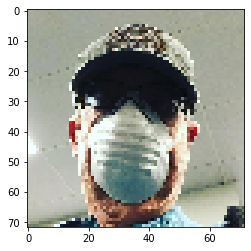

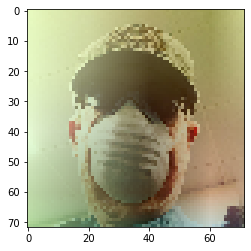

In [24]:
import cv2
import matplotlib.pyplot as plt

# read image
image = cv2.imread('example.jpg', cv2.IMREAD_COLOR)
image = image[1:1440:20,1:1440:20,:]
RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(1)
plt.imshow(RGB_img)

print("Hello")
x0 = bilateral(RGB_img[:,:,0], 20, 200)
print("x1 done")
x1 = bilateral(RGB_img[:,:,1], 20, 200)
print("x2 done")
x2 = bilateral(RGB_img[:,:,2], 20, 200)
fully_processed = cv2.merge([x0,x1,x2])
print("Done")
normalizedImg = np.zeros((1440, 1440, 3))
normalizedImg = cv2.normalize(fully_processed,  normalizedImg, 0, 255, cv2.NORM_MINMAX)

plt.figure(2)
plt.imshow(normalizedImg.astype(int))
